In [1]:
import numpy as np
import matplotlib.pyplot as plt
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from mitiq.zne.scaling import fold_gates_at_random
from mitiq.zne import inference
from qbraid import device_wrapper, job_wrapper, get_jobs

<h2>Getting folded circuits:</h2>

1. Create circuits using H and CNOT in Braket
2. Fold circuits using Mitiq
3. Decompose circuits in Braket

In [3]:
def h(qc,q0):
    qc.rz(q0,np.pi/2).v(q0).rz(q0,np.pi/2)

def cnot(qc,q0,q1):
    qc.rz(q0,-np.pi/2)
    qc.rz(q1,-np.pi).v(q1).rz(q1,-np.pi)
    qc.ecr(q0,q1)
    qc.x(q0)

def collisional_circuit(env,sys,n_col,theta):
    qc = Circuit()
    qc.h(sys).h(env[1]).cnot(env[1],env[0]).h(env[0]).h(env[1])
    for i in range(n_col):
        qc.cnot(env[1],sys[0]).rz(sys[0],2*theta).cnot(env[1],sys[0])
    qc.h(sys)
    return qc

def decompose_circuit(qc):
    qc2 = Circuit()
    for instruction in qc.instructions:
        if instruction.operator.name == 'H':
            h(qc2,instruction.target[0])
        elif instruction.operator.name == 'CNot':
            cnot(qc2,instruction.target[0],instruction.target[1])
        else:
            qc2 = qc2.add_instruction(instruction)
    return qc2

In [51]:
n = 7
g = 1
tau = np.pi/6
theta = g*tau
t = np.array(list(range(1,n+1)))*theta

def corrfunc(time):
    return (np.cos(time)**2-np.sin(time)**2)/2

sys = [5]
env = [3,4]
repcnt = 4096

<h2>Simulation:</h2>

In [5]:
local_sim = LocalSimulator()

In [6]:
res = []
for i in range(1,n+1):
    shots = 4096
    qc = collisional_circuit([1,2],[0],i,theta)
    qc2 = fold_gates_at_random(qc,3)
    qc3 = decompose_circuit(qc2)
    # verbatim_qc = Circuit().add_verbatim_box(qc)
    result = local_sim.run(qc3,shots=shots).result()
    counts = result.measurement_counts
    cnts = [0,0]
    for j in range(2**3):
        j_str = bin(j)[2:].zfill(3)
        if j_str[0] == '0':
            cnts[0] += counts.get(j_str,0)
        else:
            cnts[1] += counts.get(j_str,0)
    res.append(0.5-cnts[1]/shots)

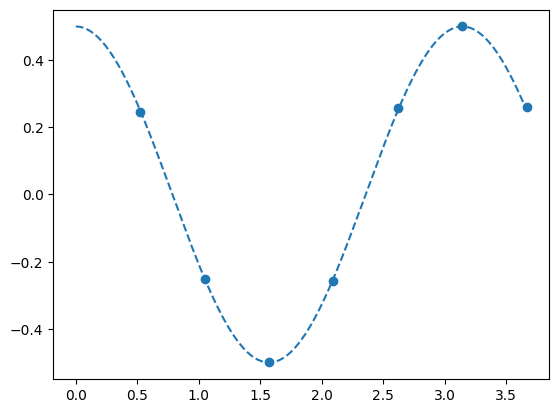

In [7]:
plt.scatter(t,res)
sim_t = np.linspace(0,t[-1],num=1000)
plt.plot(sim_t,corrfunc(sim_t),linestyle='--')
plt.show()

<h2>Running circuits on OQC Lucy:</h2>

1. Get decomposed circuits
2. Wrap in verbatim box
3. Disable qubit rewiring
4. Send

In [52]:
scale_factors = [1,3,5,7]

In [53]:
device_id = "aws_oqc_lucy"
device = device_wrapper(device_id)
print(device.metadata())

{'id': 'arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy', 'name': 'Lucy', 'provider': 'Oxford', 'vendor': 'AWS', 'numQubits': 8, 'deviceType': 'QPU', 'status': 'ONLINE', 'queueDepth': 1}


Generated circuits for scale factors [1,3,5,7] below

In [54]:
circs_list = []
for sf in scale_factors:
    for i in range(1,n+1):
        qc = collisional_circuit(env,sys,i,theta)
        qc2 = fold_gates_at_random(qc,sf)
        qc3 = decompose_circuit(qc2)
        verbatim_qc = Circuit().add_verbatim_box(qc3)
        circs_list.append(verbatim_qc)

In [55]:
print(circs_list[0])

T  : |      0      |    1    |2|    3    |    4    | 5 |    6    |   7    |   8    |   9    |   10    |11 |   12   |   13    |14|   15    |16 |   17   |18|   19   |    20     |
                                                                                                                                                                                
q3 : -StartVerbatim-Rz(-3.14)-V-Rz(-3.14)-----------ECR-Rz(1.57)--V--------Rz(1.57)---------------------------------------------------------------------------------EndVerbatim-
      |                                             |                                                                                                               |           
q4 : -|-------------Rz(1.57)--V-Rz(1.57)--Rz(-1.57)-ECR-X---------Rz(1.57)-V--------Rz(1.57)-Rz(-1.57)-ECR-X--------Rz(-1.57)--------------ECR-X--------------------|-----------
      |                                                                                                |           

<h3>Scale factor 1:</h3>

In [56]:
jobs_1 = []

In [58]:
for circ in circs_list[0:7]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_1.append(job.id)

In [59]:
print(jobs_1)

['aws_oqc_lucy-contactmainakroy-qjob-z78iwzwxipztabihw246', 'aws_oqc_lucy-contactmainakroy-qjob-v20cof8q2ei2tfovthxp', 'aws_oqc_lucy-contactmainakroy-qjob-9g6vstlbnrv6b4n0kvnu', 'aws_oqc_lucy-contactmainakroy-qjob-c2yfztj9thrrs3whs1td', 'aws_oqc_lucy-contactmainakroy-qjob-ve6pieye6f4vzu6ti3e1', 'aws_oqc_lucy-contactmainakroy-qjob-kq6o7cgafkhxmqkkhppb', 'aws_oqc_lucy-contactmainakroy-qjob-y7vbmceleffe3h1wcfj2']


<h3>Scale factor 3:</h3>

In [ ]:
jobs_3 = []

In [ ]:
for circ in circs_list[7:14]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_3.append(job.id)

In [ ]:
print(jobs_3)

<h3>Scale factor 5:</h3>

In [ ]:
jobs_5 = []

In [ ]:
for circ in circs_list[14:21]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_5.append(job.id)

In [ ]:
print(jobs_5)

<h3>Scale factor 7:</h3>

In [ ]:
jobs_7 = []

In [ ]:
for circ in circs_list[21:28]:
    job = device.run(circ,shots=repcnt,disable_qubit_rewiring=True)
    jobs_7.append(job.id)

In [ ]:
print(jobs_7)

<h2>Analysis:</h2>

In [72]:
res_1 = [job_wrapper(jobid).result()._result for jobid in jobs_1]

In [108]:
print(res_1[3].additional_metadata.oqcMetadata.compiledProgram)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
creg b[3];
rz(1.5707963267948966) q[5];
sx q[5];
rz(1.5707963267948966) q[5];
rz(1.5707963267948966) q[4];
sx q[4];
rz(1.5707963267948966) q[4];
rz(-1.5707963267948966) q[4];
rz(-3.141592653589793) q[3];
sx q[3];
rz(-3.141592653589793) q[3];
ecr q[4], q[3];
x q[4];
rz(1.5707963267948966) q[3];
sx q[3];
rz(1.5707963267948966) q[3];
rz(1.5707963267948966) q[4];
sx q[4];
rz(1.5707963267948966) q[4];
rz(-1.5707963267948966) q[4];
rz(-3.141592653589793) q[5];
sx q[5];
rz(-3.141592653589793) q[5];
ecr q[4], q[5];
x q[4];
rz(1.0471975511965976) q[5];
rz(-1.5707963267948966) q[4];
rz(-3.141592653589793) q[5];
sx q[5];
rz(-3.141592653589793) q[5];
ecr q[4], q[5];
x q[4];
rz(-1.5707963267948966) q[4];
rz(-3.141592653589793) q[5];
sx q[5];
rz(-3.141592653589793) q[5];
ecr q[4], q[5];
x q[4];
rz(1.0471975511965976) q[5];
rz(-1.5707963267948966) q[4];
rz(-3.141592653589793) q[5];
sx q[5];
rz(-3.141592653589793) q[5];
ecr q[4], q[5];
x q[4];
rz(-1.57079

In [104]:
out_1 = []
for result in res_1:
    counts = result.measurement_probabilities
    print(counts)
    cnts = [0,0]
    for j in range(2**3):
        j_str = bin(j)[2:].zfill(3)
        if j_str[0] == '0':
            cnts[0] += counts.get(j_str,0)
        else:
            cnts[1] += counts.get(j_str,0)
    out_1.append(0.5-cnts[1])

{'000': 0.229736328125, '001': 0.040771484375, '010': 0.12353515625, '011': 0.130615234375, '100': 0.186279296875, '101': 0.035888671875, '110': 0.11572265625, '111': 0.137451171875}
{'000': 0.093994140625, '001': 0.0078125, '010': 0.11865234375, '011': 0.031005859375, '100': 0.2880859375, '101': 0.02294921875, '110': 0.341796875, '111': 0.095703125}
{'000': 0.066162109375, '001': 0.0048828125, '010': 0.14599609375, '011': 0.01123046875, '100': 0.201904296875, '101': 0.0166015625, '110': 0.51611328125, '111': 0.037109375}
{'000': 0.031494140625, '001': 0.001708984375, '010': 0.1904296875, '011': 0.0078125, '100': 0.119384765625, '101': 0.004150390625, '110': 0.62109375, '111': 0.02392578125}
{'000': 0.013916015625, '001': 0.001220703125, '010': 0.211669921875, '011': 0.00732421875, '100': 0.039306640625, '101': 0.001953125, '110': 0.69775390625, '111': 0.02685546875}
{'000': 0.008056640625, '001': 0.00048828125, '010': 0.216064453125, '011': 0.01025390625, '100': 0.033447265625, '101':

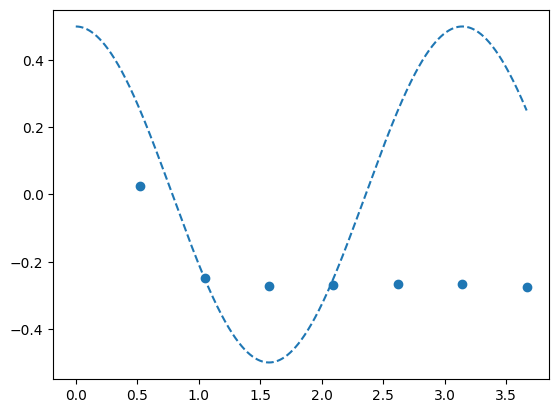

In [105]:
plt.scatter(t,out_1)
sim_t = np.linspace(0,t[-1],num=1000)
plt.plot(sim_t,corrfunc(sim_t),linestyle='--')
plt.show()